RECUPERATION DES DONNEES

In [47]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [29]:
path = "C:/Users/axell/OneDrive/Documents/ENSAE/Projet-data-science-Mornand-Merienne/CSV_data/METEOFRANCE"

df_meteo_month = []

for year in range(2020, 2024):  
    for month in range(1, 13):  
        date = f"{year}{month:02d}"  # Format "202001", "202002", etc
        file_name = f"synop.{date}.csv.gz"
        file_path = os.path.join(path, file_name)
        try:
            df = pd.read_csv(file_path, compression='gzip', sep=';', encoding='utf-8')
            df_meteo_month.append(df)  # Ajouter chaque DataFrame à la liste
        except FileNotFoundError:
            print(f"Fichier non trouvé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")

df_meteo = pd.concat(df_meteo_month, ignore_index=True)

print(df_meteo.head())

   numer_sta            date    pmer tend cod_tend   dd        ff           t  \
0       7005  20200101000000  103180  -80        8  120  1.800000  274.350000   
1       7015  20200101000000  103320    0        5   80  4.700000  275.250000   
2       7020  20200101000000  102870  -70        8   80  1.300000  280.550000   
3       7027  20200101000000  103080    0        0  100  4.200000  275.750000   
4       7037  20200101000000  103190  -30        8  130  2.200000  272.250000   

           td    u  ... nnuage2 ctype2 hnuage2 nnuage3 ctype3 hnuage3 nnuage4  \
0  272.750000   89  ...      mq     mq      mq      mq     mq      mq      mq   
1  275.150000   99  ...      mq     mq      mq      mq     mq      mq      mq   
2  279.450000   93  ...      mq     mq      mq      mq     mq      mq      mq   
3  275.750000  100  ...      mq     mq      mq      mq     mq      mq      mq   
4  272.250000  100  ...      mq     mq      mq      mq     mq      mq      mq   

  ctype4 hnuage4 Unnamed: 

In [30]:
print(df_meteo.columns)

Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch',
       'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24',
       'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4', 'Unnamed: 59'],
      dtype='object')


In [31]:
colonnes_a_garder = ['numer_sta', 'date', 'pmer', 'tend', 'dd', 'ff', 't', 'u', 'vv', 'rr12']
noms_colonnes = {
    'numer_sta': 'ID',
    'date': 'date_UTC',
    'pmer': 'pression_niveau_mer_Pa',
    'tend': 'var_pression_3h_Pa',
    'dd': 'direction_vent_moyen_10mn_deg',
    'ff': 'vitesse_vent_moyen_10mn_m/s',
    't': 'temperature_K',
    'u': 'humidite_%',
    'vv': 'visibilite_horizontale_m',
    'rr12': 'precipitations_12h_mm'
}

df_meteo = df_meteo[colonnes_a_garder]
df_meteo = df_meteo.rename(columns=noms_colonnes)


In [32]:
def filtre_mesure_minuit(df):
    # Convertir la colonne date_UTC au format datetime
    df['date_UTC'] = pd.to_datetime(df['date_UTC'], format='%Y%m%d%H%M%S', errors='coerce')
    
    # Filtrer les lignes correspondant à minuit (heure, minute et seconde égales à 0)
    df_minuit = df[(df['date_UTC'].dt.hour == 0) & 
                   (df['date_UTC'].dt.minute == 0) & 
                   (df['date_UTC'].dt.second == 0)]
    
    return df_minuit

# Appliquer cette fonction de filtrage 
df_meteo = filtre_mesure_minuit(df_meteo)  # Garder seulement les mesures à minuit
df_meteo['date_UTC'] = df_meteo['date_UTC'].dt.strftime('%Y-%m-%d')

print(df_meteo.head())


     ID    date_UTC pression_niveau_mer_Pa var_pression_3h_Pa  \
0  7005  2020-01-01                 103180                -80   
1  7015  2020-01-01                 103320                  0   
2  7020  2020-01-01                 102870                -70   
3  7027  2020-01-01                 103080                  0   
4  7037  2020-01-01                 103190                -30   

  direction_vent_moyen_10mn_deg vitesse_vent_moyen_10mn_m/s temperature_K  \
0                           120                    1.800000    274.350000   
1                            80                    4.700000    275.250000   
2                            80                    1.300000    280.550000   
3                           100                    4.200000    275.750000   
4                           130                    2.200000    272.250000   

  humidite_% visibilite_horizontale_m precipitations_12h_mm  
0         89                     9290              0.000000  
1         99          

In [33]:
path = "C:/Users/axell/OneDrive/Documents/ENSAE/Projet-data-science-Mornand-Merienne/CSV_data/METEOFRANCE/postesSynop.json"
stations_gdf = gpd.read_file(path)
print(stations_gdf.head())
print(stations_gdf.crs)


      ID              Nom   Latitude  Longitude Altitude  \
0  07005        ABBEVILLE  50.136000   1.834000       69   
1  07015    LILLE-LESQUIN  50.570000   3.097500       47   
2  07020  PTE DE LA HAGUE  49.725167  -1.939833        6   
3  07027   CAEN-CARPIQUET  49.180000  -0.456167       67   
4  07037       ROUEN-BOOS  49.383000   1.181667      151   

                    geometry  
0       POINT (1.834 50.136)  
1       POINT (3.0975 50.57)  
2  POINT (-1.93983 49.72517)  
3     POINT (-0.45617 49.18)  
4     POINT (1.18167 49.383)  
EPSG:4326


In [ ]:
stations_df = pd.DataFrame(stations_gdf)
print(stations_df['Longitude'].dtype)

#On doit convertir les données des colonnes longitude et latitude en données numériques pour pouvoir les plotter
stations_df['Longitude'] = pd.to_numeric(stations_df['Longitude'], errors='coerce')
stations_df['Latitude'] = pd.to_numeric(stations_df['Latitude'], errors='coerce')

print(stations_df.head())

object
      ID              Nom   Latitude  Longitude Altitude  \
0  07005        ABBEVILLE  50.136000   1.834000       69   
1  07015    LILLE-LESQUIN  50.570000   3.097500       47   
2  07020  PTE DE LA HAGUE  49.725167  -1.939833        6   
3  07027   CAEN-CARPIQUET  49.180000  -0.456167       67   
4  07037       ROUEN-BOOS  49.383000   1.181667      151   

                    geometry  
0       POINT (1.834 50.136)  
1       POINT (3.0975 50.57)  
2  POINT (-1.93983 49.72517)  
3     POINT (-0.45617 49.18)  
4     POINT (1.18167 49.383)  


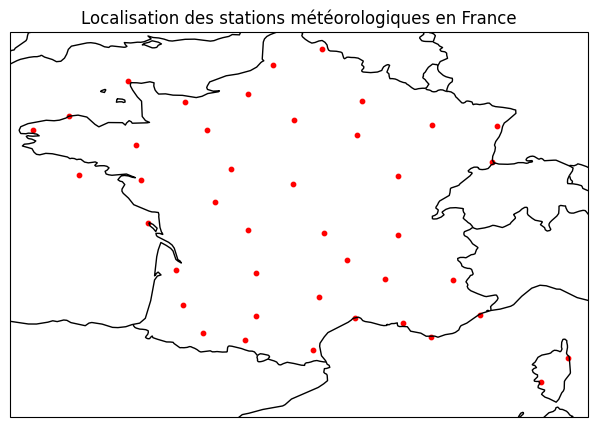

In [35]:
# Créer la figure
fig = plt.figure(figsize=(9, 5))

# Sélectionner une projection pour la carte
ax = plt.axes(projection=ccrs.PlateCarree())

# Tracer les stations avec leurs coordonnées (lon, lat) de toutes les stations
scatter = ax.scatter(stations_df['Longitude'], stations_df['Latitude'], color='red', s=10, label='Stations')

# Ajouter les éléments géographiques : côtes et frontières
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Définir la région à afficher pour toute la France
ax.set_extent([-5, 10, 41, 51])  # Coordonnées approximatives pour toute la France

# Ajouter un titre à la carte
plt.title("Localisation des stations météorologiques en France")

# Afficher la carte
plt.show()

In [ ]:
stations_df['ID'] = pd.to_numeric(stations_df['ID'], errors='coerce')
df_meteo_tot = pd.merge(df_meteo, stations_df, how='left', on='ID')
df_meteo_tot = df_meteo_tot.drop(['Altitude', 'geometry'], axis=1)
print(df_meteo_tot.head())


     ID    date_UTC pression_niveau_mer_Pa var_pression_3h_Pa  \
0  7005  2020-01-01                 103180                -80   
1  7015  2020-01-01                 103320                  0   
2  7020  2020-01-01                 102870                -70   
3  7027  2020-01-01                 103080                  0   
4  7037  2020-01-01                 103190                -30   

  direction_vent_moyen_10mn_deg vitesse_vent_moyen_10mn_m/s temperature_K  \
0                           120                    1.800000    274.350000   
1                            80                    4.700000    275.250000   
2                            80                    1.300000    280.550000   
3                           100                    4.200000    275.750000   
4                           130                    2.200000    272.250000   

  humidite_% visibilite_horizontale_m precipitations_12h_mm              Nom  \
0         89                     9290              0.000000       

In [ ]:
colonnes_a_exclure = ['date_UTC', 'Latitude', 'Longitude','Nom']

# Sélectionner toutes les colonnes sauf celles à exclure 
colonnes_a_convertir = [col for col in df_meteo_tot.columns if col not in colonnes_a_exclure]

# Appliquer la conversion en numérique à toutes les colonnes sélectionnées (pour pouvoir décrire les données)
df_meteo_tot[colonnes_a_convertir] = df_meteo_tot[colonnes_a_convertir].apply(pd.to_numeric, errors='coerce')
df_meteo_tot['date_UTC'] = pd.to_datetime(df_meteo_tot['date_UTC'], errors='coerce')

df_meteo_tot['temperature_C'] = df_meteo_tot['temperature_K'] - 273.15
df_meteo_tot = df_meteo_tot.drop('temperature_K',axis=1)


ANALYSE DES DONNEES

In [53]:
print(df_meteo_tot.shape)

(86772, 13)


In [77]:
colonnes_a_etudier = ['pression_niveau_mer_Pa', 'var_pression_3h_Pa', 'direction_vent_moyen_10mn_deg', 'vitesse_vent_moyen_10mn_m/s', 'temperature_C', 'humidite_%', 'visibilite_horizontale_m', 'precipitations_12h_mm']
print(df_meteo_tot[colonnes_a_etudier].describe())

       pression_niveau_mer_Pa  var_pression_3h_Pa  \
count            81278.000000        84599.000000   
mean            101608.598883           25.371104   
std                899.022990          124.397644   
min              94120.000000        -1410.000000   
25%             101210.000000          -50.000000   
50%             101620.000000           20.000000   
75%             102120.000000          110.000000   
max             104890.000000         1310.000000   

       direction_vent_moyen_10mn_deg  vitesse_vent_moyen_10mn_m/s  \
count                   85867.000000                 85874.000000   
mean                      172.927201                     3.776962   
std                       105.578838                     3.191799   
min                         0.000000                     0.000000   
25%                        80.000000                     1.600000   
50%                       170.000000                     2.900000   
75%                       260.000000   

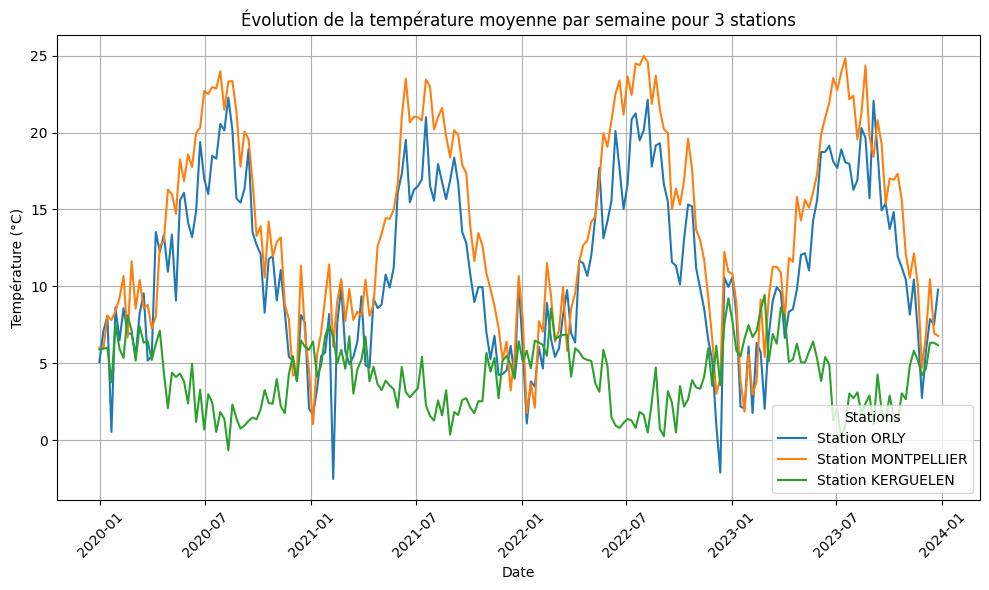

In [96]:
stations_choisies = ['ORLY', 'MONTPELLIER','KERGUELEN']

# Filtrer les données pour ces trois stations
df_stations = df_meteo_tot[df_meteo_tot['Nom'].isin(stations_choisies)]
df_stations = df_stations.copy()  

# Créer une colonne 'week' pour obtenir la semaine
df_stations['week'] = df_stations['date_UTC'].dt.to_period('W')

# Calculer la température moyenne par semaine pour chaque station
df_monthly = df_stations.groupby(['Nom', 'week'])['temperature_C'].mean().reset_index()

# Tracer l'évolution de la température par semaine pour chaque station
plt.figure(figsize=(10, 6))

for station in stations_choisies:
    station_data = df_monthly[df_monthly['Nom'] == station]
    plt.plot(station_data['week'].dt.start_time, station_data['temperature_C'], label=f"Station {station}")

# Ajouter des labels et un titre
plt.title("Évolution de la température moyenne par semaine pour 3 stations")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.legend(title="Stations")

# Afficher le graphe
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()